In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import utils
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3 # Farklı önceden eğitilmiş modelleri deneyebiliriz
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# TensorFlow versiyonunu kontrol edelim
print(f"TensorFlow Version: {tf.__version__}")

# GPU kullanılabilirliğini kontrol edelim
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU is available!")
else:
    print("GPU is NOT available. Training might be slow.")

# --- 2. Global Sabitleri Tanımlama ---
# utils.py dosyasındaki sabitleri burada da kullanabiliriz
IMG_SIZE = utils.IMG_SIZE # (224, 224)
BATCH_SIZE = utils.BATCH_SIZE # 32
ORIGINAL_DATA_PATH = utils.ORIGINAL_DATA_PATH
AUGMENTED_DATA_PATH = utils.AUGMENTED_DATA_PATH

TensorFlow Version: 2.10.1
Num GPUs Available:  1
GPU is available!


In [8]:
# Orijinal DataFrameleri yükle
original_train_df = utils.load_data(subset='train', base_path=ORIGINAL_DATA_PATH)
original_valid_df = utils.load_data(subset='valid', base_path=ORIGINAL_DATA_PATH)
original_test_df = utils.load_data(subset='test', base_path=ORIGINAL_DATA_PATH)

print("\nOrijinal Veri Seti Dağılımı:")
print(f"Train set: {len(original_train_df)} images")
print(f"Validation set: {len(original_valid_df)} images")
print(f"Test set: {len(original_test_df)} images")

print("\nOrijinal Eğitim Seti Etiket Dağılımı:")
print(f"Moderate Accident: {original_train_df['moderate'].sum()}")
print(f"Severe Accident: {original_train_df['severe'].sum()}")
print(f"No Accident: {original_train_df['no_accident'].sum()}")


Orijinal Veri Seti Dağılımı:
Train set: 10469 images
Validation set: 1004 images
Test set: 649 images

Orijinal Eğitim Seti Etiket Dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259


In [9]:
# Artırılmış veri setlerini yükle
train_df = utils.load_data(subset='train', base_path=AUGMENTED_DATA_PATH)
valid_df = utils.load_data(subset='valid', base_path=AUGMENTED_DATA_PATH)
test_df = utils.load_data(subset='test', base_path=AUGMENTED_DATA_PATH)

print(f"Güncel Train set: {len(train_df)} images")
print(f"Güncel Validation set: {len(valid_df)} images")
print(f"Güncel Test set: {len(test_df)} images")

print("\nGüncel Eğitim seti etiket dağılımı:")
print(f"Moderate Accident: {train_df['moderate'].sum()}")
print(f"Severe Accident: {train_df['severe'].sum()}")
print(f"No Accident: {train_df['no_accident'].sum()}")
multi_label_train_aug = train_df[(train_df['moderate'] == 1) & (train_df['severe'] == 1)]
print(f"Multi-label (Moderate & Severe): {len(multi_label_train_aug)}")


# TensorFlow Dataset nesneleri oluştur
train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(valid_df)
test_dataset = utils.create_dataset(test_df)

Güncel Train set: 16944 images
Güncel Validation set: 1602 images
Güncel Test set: 649 images

Güncel Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 6734
Multi-label (Moderate & Severe): 45


In [10]:
BASE_MODEL = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Temel modelin katmanlarını dondurun
# Bu, önceden eğitilmiş ağırlıkların eğitim sırasında değişmesini engeller.
BASE_MODEL.trainable = False

# Modeli oluşturun
def create_transfer_model(base_model):
    """
    Önceden eğitilmiş bir temel model üzerine özel katmanlar ekleyerek
    transfer öğrenme modeli oluşturur.

    Args:
        base_model (tf.keras.Model): Önceden eğitilmiş temel model (örn. ResNet50V2).
        num_classes (int): Çıkış katmanındaki sınıf sayısı.

    Returns:
        tf.keras.Model: Derlenmeye hazır transfer öğrenme modeli.
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x) # Özellik haritalarından ortalama alarak tek bir vektör oluşturur

    # Yeni özel katmanları ekleyin
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) # Overfitting'i azaltmak için Dropout

    # Çıkış katmanı (softmax çoklu sınıf sınıflandırması için)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_transfer_model(BASE_MODEL)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', # Çoklu sınıf sınıflandırması için
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [11]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Doğrulama kaybını izle
        patience=8,         # 8 epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True # En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', # Doğrulama kaybı durursa
        factor=0.5,         # Öğrenme oranını %50 azalt
        patience=3,         # 3 epoch boyunca iyileşme olmazsa uygula
        min_lr=1e-7,        # En düşük learning rate oranı
        verbose=1           # LR düştüğünde çıktı versin
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_transfer_model.h5", # En iyi modeli kaydet
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

In [12]:
EPOCHS = 50

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
530/530 [==============================] - ETA: 0s - loss: 0.9140 - accuracy: 0.6602
Epoch 1: val_loss improved from inf to 0.48124, saving model to best_transfer_model.h5
530/530 [==============================] - 84s 151ms/step - loss: 0.9140 - accuracy: 0.6602 - val_loss: 0.4812 - val_accuracy: 0.8171 - lr: 1.0000e-04
Epoch 2/50
530/530 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7996
Epoch 2: val_loss improved from 0.48124 to 0.42571, saving model to best_transfer_model.h5
530/530 [==============================] - 79s 150ms/step - loss: 0.5324 - accuracy: 0.7996 - val_loss: 0.4257 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 3/50
530/530 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8513
Epoch 3: val_loss improved from 0.42571 to 0.42457, saving model to best_transfer_model.h5
530/530 [==============================] - 81s 153ms/step - loss: 0.4008 - accuracy: 0.8513 - val_loss: 0.4246 - val_accuracy: 0.8539 - lr: 1

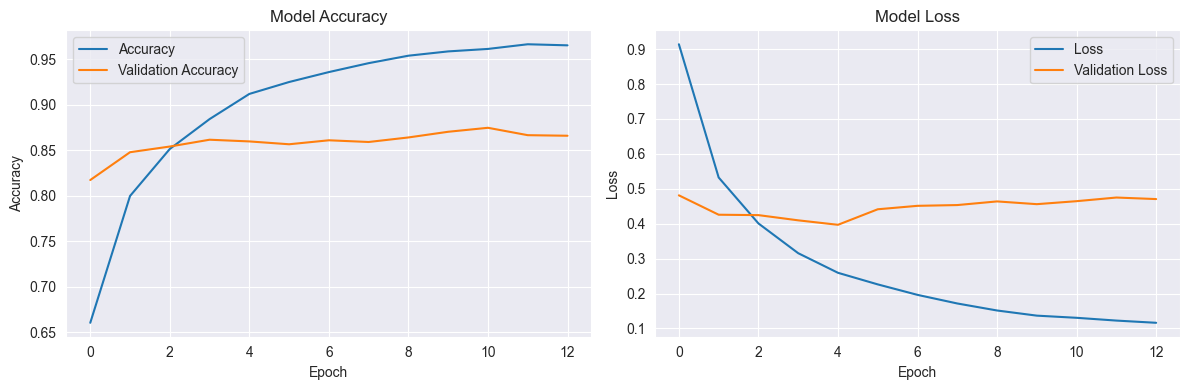

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Test Seti Üzerinde Model Değerlendirmesi:
Accuracy: 0.8983
F1 Score: 0.9009
ROC-AUC Score: 0.9812


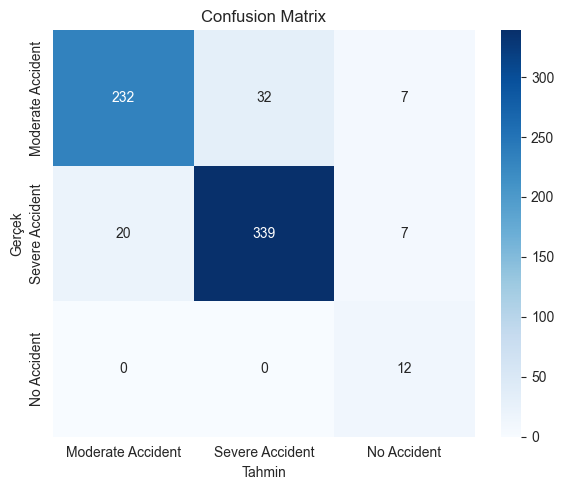


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.92      0.86      0.89       271
  Severe Accident       0.91      0.93      0.92       366
      No Accident       0.46      1.00      0.63        12

         accuracy                           0.90       649
        macro avg       0.77      0.93      0.81       649
     weighted avg       0.91      0.90      0.90       649



In [15]:
print("\nTest Seti Üzerinde Model Değerlendirmesi:")
# Kaydedilen en iyi modeli yükle
best_model = tf.keras.models.load_model("best_transfer_model.h5")

class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(best_model, test_dataset, class_names)


Rastgele Seçilen Test Görüntülerinde Tahminleri Görselleştirme:


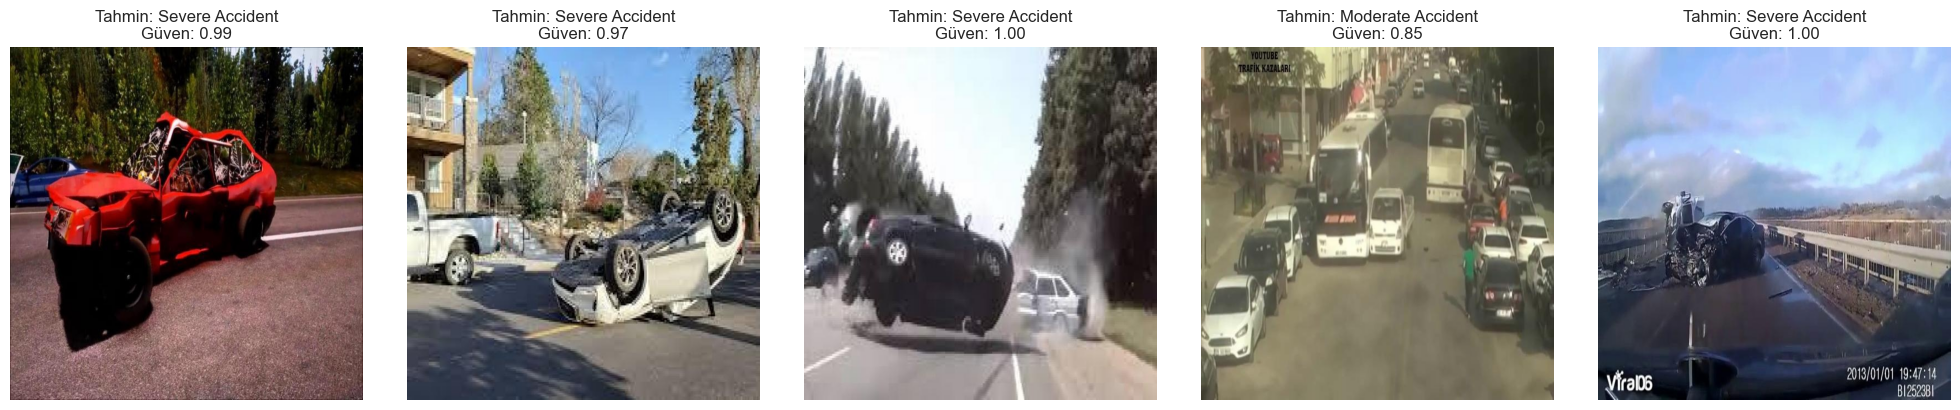

In [17]:
print("\nRastgele Seçilen Test Görüntülerinde Tahminleri Görselleştirme:")
utils.visualize_predictions(best_model, test_df['filename'].values, class_names=class_names, num_images=5)